# Sequence Learning - Direct - English - Testing Session - Reconstruction
Version 2: encode all validation set tokens, but keeping only those that are "matching" (= match_status==1)

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import plotly.express as px
import random
from sklearn.manifold import TSNE  # Optional: Use t-SNE for dimensionality reduction
import seaborn as sns
from collections import Counter
import librosa
from IPython.display import Audio

In [2]:
from padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from my_utils import *
from loss import *
from model import SimplerPhxLearner, LHYPhxLearner, TwoLinPhxLearner
from dataset import SeqDatasetName, MelSpecTransform, MelSpecTransformNew, Normalizer, DeNormalizer
from my_dataset import DS_Tools
from reshandler import ReconResHandler
from misc_progress_bar import draw_progress_bar
from bnd_detect_tools import *

## Preps

### Dirs

In [3]:
model_save_dir = model_eng_save_dir

log_path = compound_word_log_path
rec_path = word_seg_anno_path

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Model

### Model-related defs

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

# model = SimplerPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = LHYPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model = TwoLinPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [6]:
load_ts = "0122115907"
stop_epoch = "49"

In [7]:
model_raw_name = "PT_{}_{}_full".format(load_ts, stop_epoch)
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

TwoLinPhxLearner(
  (encoder): LRLEncoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (rnn): LSTM(32, 16, num_layers=2, batch_first=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): LRALDecoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (rnn): LSTM(32, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): Linear(in_features=8, out_features=64, bias=True)
  )
)

### Dataset

- Note that due to the separate setting of word and phone datasets, we cannot really make it to select those that have not been trained on 
for this test. This is a point to further fix. Make reference to out first work. 

In [8]:
mytrans = MelSpecTransformNew(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS, normalizer=Normalizer.norm_strip_mvn, denormalizer=DeNormalizer.norm_strip_mvn)
ds = SeqDatasetName(rec_path, os.path.join(log_path, "log.csv"), transform=mytrans)

# Cannot load dataset trained, data filtering applied
valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(load_ts)))

valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

# # this is to reduce the size of the dataset when the training power is not sufficient
# small_len = int(0.5 * len(ds))
# other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
# valid_ds, other_ds = random_split(ds, [small_len, other_len])

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=SeqDatasetName.collate_fn)
valid_num = len(valid_loader.dataset)

In [9]:
valid_num

56808

## Inference

In [10]:
def infer(): 
    model.eval()
    reshandler = ReconResHandler(whole_res_dir=compound_plot_res_path, file_prefix="recon_" + model_raw_name)
    all_res = []
    all_ori = []
    all_name = []

    total = len(valid_loader)

    for idx, (x, x_lens, name) in enumerate(valid_loader): 
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        recon_x, attn_weight = model(x, x_lens, x_mask)

        recon_x = recon_x.cpu().detach().numpy().squeeze()
        ori_x = x.cpu().detach().numpy().squeeze()

        all_res += [recon_x]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_ori += [ori_x]
        all_name += [name]

        if idx % 10 == 0: 
            draw_progress_bar(idx, total)
    

    reshandler.res = all_res
    reshandler.tok = all_ori
    reshandler.name = all_name
    reshandler.save()

In [11]:
if __name__ == "__main__": 
    infer()

[==================================================] 99%	

# Load Res

In [12]:
reshandler = ReconResHandler(whole_res_dir=compound_plot_res_path, file_prefix="recon_" + model_raw_name)
reshandler.read()

# Plot some recon and original comparisons

In [13]:
# all
all_recon = reshandler.res
all_ori = reshandler.tok
all_name = reshandler.name

In [14]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [55]:
i = random.randint(0, len(all_name))

In [56]:
reshandler.name[i]

's2802a_00001594'

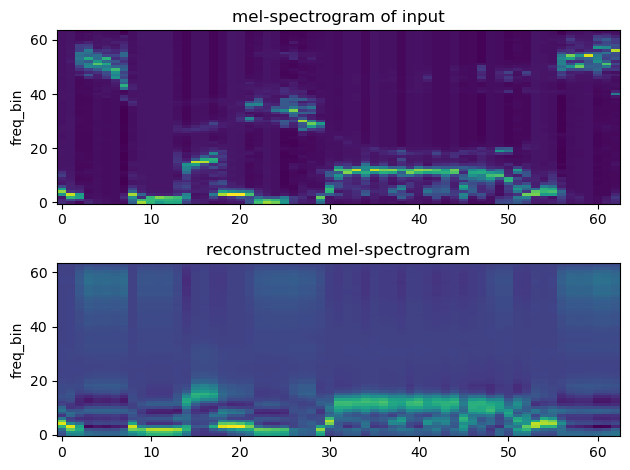

In [57]:
fig, axs = plt.subplots(2, 1)
plot_spectrogram(all_ori[i].T, title="mel-spectrogram of input", ax=axs[0])
plot_spectrogram(all_recon[i].T, title="reconstructed mel-spectrogram", ax=axs[1])
fig.tight_layout()

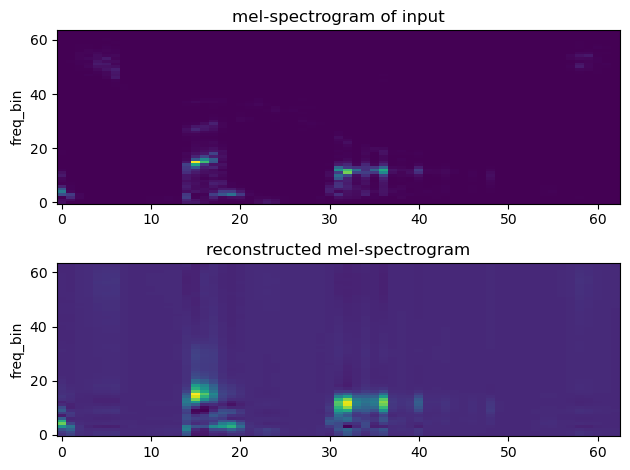

In [58]:
rec, rate = torchaudio.load(os.path.join(rec_path, all_name[i] + ".wav"))

fig, axs = plt.subplots(2, 1)
plot_spectrogram(mytrans.de_norm(torch.from_numpy(all_ori[i]), rec).numpy().T, title="mel-spectrogram of input", ax=axs[0])
plot_spectrogram(mytrans.de_norm(torch.from_numpy(all_recon[i]), rec).numpy().T, title="reconstructed mel-spectrogram", ax=axs[1])
fig.tight_layout()

In [59]:
Audio(rec.numpy(), rate=rate)

In [60]:
Audio(mytrans.inverse(mytrans.de_norm(torch.from_numpy(all_ori[i]), rec)).numpy(), rate=REC_SAMPLE_RATE)

In [61]:
Audio(mytrans.inverse(mytrans.de_norm(torch.from_numpy(all_recon[i]), rec)).numpy(), rate=REC_SAMPLE_RATE)

In [62]:
Audio(mytrans.inverse(torch.from_numpy(all_ori[i])).numpy(), rate=REC_SAMPLE_RATE)

In [63]:
Audio(mytrans.inverse(torch.from_numpy(all_recon[i])).numpy(), rate=REC_SAMPLE_RATE)